## Time Series

В данном ноутбуке в качестве данных будем использовать инфляцию, курс доллара, величину процентной ставки, а также лаговые переменные всех этих признаков и целевой переменной. Будем работать как с временным рядом, расчитаем лаговые признаки и попробуем в качестве классификатора Random Forest, KNN и CatBoost.

In [1]:
import os
import sys

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import optuna

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics

c:\Users\user\miniconda3\envs\ml_yp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# загружаем данные
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

### Lag Feature and Random Forest

Добавим лаговые признаки таргета с лагом от 1 до 5 включительно.

In [3]:
for i in range(1, 6):
    X[f"lag{i}_target"] = y.shift(i)

Проверим качество с помощью кросс-валидации

              precision    recall  f1-score   support

        -1.0       0.60      0.38      0.46        24
         0.0       0.44      0.54      0.48        28
         1.0       0.59      0.68      0.63        19

    accuracy                           0.52        71
   macro avg       0.54      0.53      0.53        71
weighted avg       0.53      0.52      0.52        71



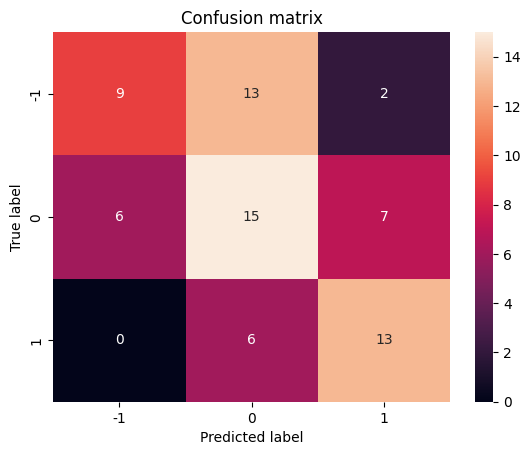

In [4]:
metric, model = calc_metrics(
    X.filter(regex="target").values,  # обучаемся только на лаговых признаках
    y.values,
    RandomForestClassifier,
    name="lag target Random Forest",
    calc_jobs=-1,
    random_state=42,
)

In [5]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.704225,0.708239,0.708229,0.711692,0.819984,0.823556
K-neighbors tf_idf pca,0.676056,0.687194,0.684106,0.690773,0.801532,0.806358
K-neighbors word2vec,0.647887,0.629487,0.628759,0.739583,0.773496,0.776707
K-neighbors weighted word2vec,0.647887,0.629487,0.628759,0.739583,0.788023,0.789826
lag target Random Forest,0.521127,0.526519,0.531642,0.544029,0.731007,0.738598


Попробуем добавить процентную ставку и четыре лаговых признака процентной ставки

In [6]:
for i in range(1, 5):
    X[f"lag{i}_rate"] = X["rate"].shift(i)

Взглянем на качество

              precision    recall  f1-score   support

        -1.0       0.62      0.54      0.58        24
         0.0       0.51      0.64      0.57        28
         1.0       0.80      0.63      0.71        19

    accuracy                           0.61        71
   macro avg       0.64      0.61      0.62        71
weighted avg       0.63      0.61      0.61        71



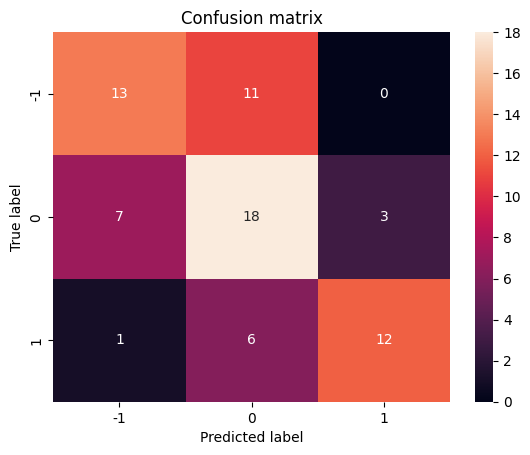

In [7]:
metric, model = calc_metrics(
    # отбираем колонки содержащие в названии target или rate
    X.filter(regex=r"(target)|(rate)").values,
    y.values,
    RandomForestClassifier,
    name="lag target, rate Random Forest",
    calc_jobs=-1,
    random_state=42,
)

In [8]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.704225,0.708239,0.708229,0.711692,0.819984,0.823556
K-neighbors tf_idf pca,0.676056,0.687194,0.684106,0.690773,0.801532,0.806358
K-neighbors word2vec,0.647887,0.629487,0.628759,0.739583,0.773496,0.776707
K-neighbors weighted word2vec,0.647887,0.629487,0.628759,0.739583,0.788023,0.789826
lag target Random Forest,0.521127,0.526519,0.531642,0.544029,0.731007,0.738598
"lag target, rate Random Forest",0.605634,0.618363,0.605368,0.644444,0.731230,0.739525


Качество подросло, теперь попробуем добавить значение курса доллара и четыре его лаговых признака

In [9]:
for i in range(1, 5):
    X[f"lag{i}_usd"] = X["usd"].shift(i)

              precision    recall  f1-score   support

        -1.0       0.62      0.42      0.50        24
         0.0       0.49      0.71      0.58        28
         1.0       0.79      0.58      0.67        19

    accuracy                           0.58        71
   macro avg       0.63      0.57      0.58        71
weighted avg       0.61      0.58      0.58        71



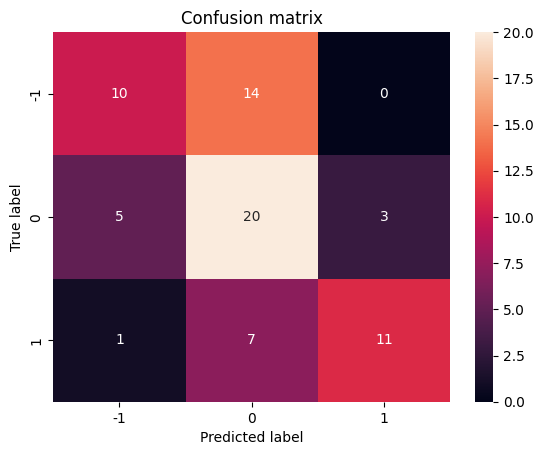

In [10]:
metric, model = calc_metrics(
    # отбираем необходимые признаки
    X.filter(regex=r"(target)|(rate)|(usd)").values,
    y.values,
    RandomForestClassifier,
    name="lag target, rate, usd Random Forest",
    calc_jobs=-1,
    random_state=42,
)

In [11]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.704225,0.708239,0.708229,0.711692,0.819984,0.823556
K-neighbors tf_idf pca,0.676056,0.687194,0.684106,0.690773,0.801532,0.806358
K-neighbors word2vec,0.647887,0.629487,0.628759,0.739583,0.773496,0.776707
K-neighbors weighted word2vec,0.647887,0.629487,0.628759,0.739583,0.788023,0.789826
lag target Random Forest,0.521127,0.526519,0.531642,0.544029,0.731007,0.738598
"lag target, rate Random Forest",0.605634,0.618363,0.605368,0.644444,0.731230,0.739525
"lag target, rate, usd Random Forest",0.577465,0.582126,0.569967,0.632840,0.752053,0.759921


Наша основная метрика немно выросла, хотя accuracy, f1, recall и precision снизились. Если мы поиграемся с порогом то эти метрики тоже станут выше. Попробуем добавить инфляцию.

In [12]:
for i in range(1, 5):
    X[f"lag{i}_inflation"] = X["inflation"].shift(i)

              precision    recall  f1-score   support

        -1.0       0.82      0.58      0.68        24
         0.0       0.56      0.71      0.62        28
         1.0       0.72      0.68      0.70        19

    accuracy                           0.66        71
   macro avg       0.70      0.66      0.67        71
weighted avg       0.69      0.66      0.67        71



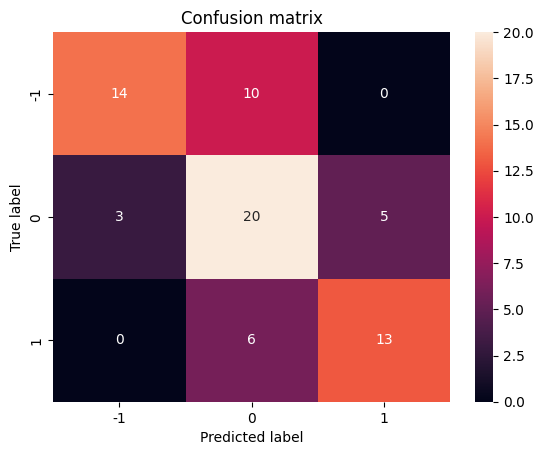

In [13]:
metric, model = calc_metrics(
    # отбираем необходимые признаки
    X.filter(regex=r"(target)|(rate)|(usd)|(inflation)").values,
    y.values,
    RandomForestClassifier,
    name="lag target, rate, usd, inflation Random Forest",
    calc_jobs=-1,
    random_state=42,
)

In [14]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.704225,0.708239,0.708229,0.711692,0.819984,0.823556
K-neighbors tf_idf pca,0.676056,0.687194,0.684106,0.690773,0.801532,0.806358
K-neighbors word2vec,0.647887,0.629487,0.628759,0.739583,0.773496,0.776707
K-neighbors weighted word2vec,0.647887,0.629487,0.628759,0.739583,0.788023,0.789826
lag target Random Forest,0.521127,0.526519,0.531642,0.544029,0.731007,0.738598
"lag target, rate Random Forest",0.605634,0.618363,0.605368,0.644444,0.731230,0.739525
"lag target, rate, usd Random Forest",0.577465,0.582126,0.569967,0.632840,0.752053,0.759921
"lag target, rate, usd, inflation Random Forest",0.661972,0.670210,0.660610,0.700436,0.748025,0.753910


Теперь добавим рост каждого показателя(во сколько раз вырос показатель). И добавим лаговые признаки по каждому такому показателю.

In [15]:
for column in ("inflation", "rate", "usd"):
    X[f"growth_{column}"] = X[column] / X[column].shift(1)

In [16]:
for column in X.filter(regex="growth").columns:
    for i in range(1, 5):
        X[f"lag{i}_{column}"] = X[column].shift(i)

              precision    recall  f1-score   support

        -1.0       0.75      0.62      0.68        24
         0.0       0.57      0.71      0.63        28
         1.0       0.81      0.68      0.74        19

    accuracy                           0.68        71
   macro avg       0.71      0.67      0.69        71
weighted avg       0.70      0.68      0.68        71



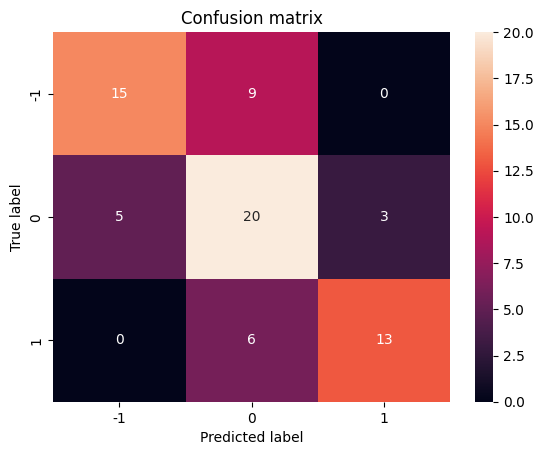

In [17]:
metric, model = calc_metrics(
    # отбираем необходимые признаки
    X.filter(regex=r"(target)|(rate)|(usd)|(inflation)").values,
    y.values,
    RandomForestClassifier,
    name="lag target, rate, usd, inflation, growth Random Forest",
    calc_jobs=-1,
    random_state=42,
)

In [18]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.704225,0.708239,0.708229,0.711692,0.819984,0.823556
K-neighbors tf_idf pca,0.676056,0.687194,0.684106,0.690773,0.801532,0.806358
K-neighbors word2vec,0.647887,0.629487,0.628759,0.739583,0.773496,0.776707
K-neighbors weighted word2vec,0.647887,0.629487,0.628759,0.739583,0.788023,0.789826
lag target Random Forest,0.521127,0.526519,0.531642,0.544029,0.731007,0.738598
"lag target, rate Random Forest",0.605634,0.618363,0.605368,0.644444,0.731230,0.739525
"lag target, rate, usd Random Forest",0.577465,0.582126,0.569967,0.632840,0.752053,0.759921
"lag target, rate, usd, inflation Random Forest",0.661972,0.670210,0.660610,0.700436,0.748025,0.753910
"lag target, rate, usd, inflation, growth Random Forest",0.676056,0.686532,0.674499,0.711310,0.759706,0.765801


Попробуем подобрать количество лаговых признаков и гиперпараметры `RandomForestClassifier`

### Random Forest tuning hyperparameters

In [19]:
# удалим все лаговые переменные
X = pd.read_csv("../data/x.csv", index_col="date")

In [20]:
def objective(trial):

    # параметры для перебора
    params = {
        "n_lags": trial.suggest_int("n_lags", 2, 5),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    }

    features = ["inflation", "rate", "usd"]

    # Создаем копию признаков
    data = X[features].copy()

    # добавляем лаги целевой переменной
    for i in range(1, params["n_lags"] + 1):
        data[f"lag{i}_target"] = y.shift(i)

    # для всех экзогенных признаков
    for feature in ["inflation", "rate", "usd"]:
        # добавляем рост
        data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
        features.append(f"growth_{feature}")

    # для всех признаков добавляем лаги
    for feature in features:
        for i in range(1, params["n_lags"]):
            data[f"lag{i}_{feature}"] = data[feature].shift(i)

    model = RandomForestClassifier(
        max_depth=params["max_depth"],
        min_samples_leaf=params["min_samples_leaf"],
        min_samples_split=params["min_samples_split"],
        random_state=42,
    )

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(data.values, y, model, name=" ", plot=False, calc_jobs=-1)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300, show_progress_bar=True)

Best trial: 179. Best value: 0.777869: 100%|██████████| 300/300 [02:58<00:00,  1.68it/s]


In [21]:
study.best_params

{'n_lags': 5, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 7}

Посмотрим метрики подробнее

              precision    recall  f1-score   support

        -1.0       0.73      0.46      0.56        24
         0.0       0.51      0.75      0.61        28
         1.0       0.73      0.58      0.65        19

    accuracy                           0.61        71
   macro avg       0.66      0.60      0.61        71
weighted avg       0.65      0.61      0.60        71



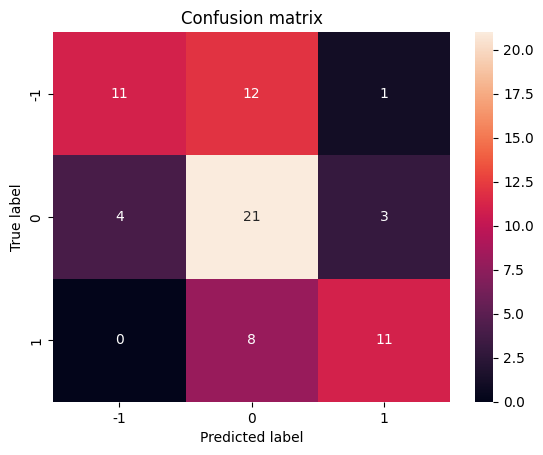

In [22]:
features = ["inflation", "rate", "usd"]

# Создаем копию признаков
data = X[features].copy()

# добавляем лаги целевой переменной
for i in range(1, study.best_params["n_lags"] + 1):
    data[f"lag{i}_target"] = y.shift(i)

# для всех экзогенных признаков
for feature in ["inflation", "rate", "usd"]:
    # добавляем рост
    data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
    features.append(f"growth_{feature}")

# для всех признаков добавляем лаги
for feature in features:
    for i in range(1, study.best_params["n_lags"]):
        data[f"lag{i}_{feature}"] = data[feature].shift(i)

model = RandomForestClassifier(
    max_depth=study.best_params["max_depth"],
    min_samples_leaf=study.best_params["min_samples_leaf"],
    min_samples_split=study.best_params["min_samples_split"],
    random_state=42,
)

# считаем метрики на кросс валидации
metric, _ = calc_metrics(data.values, y, model, name="TimeSeries way Random Forest", calc_jobs=-1)

In [23]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.704225,0.708239,0.708229,0.711692,0.819984,0.823556
K-neighbors tf_idf pca,0.676056,0.687194,0.684106,0.690773,0.801532,0.806358
K-neighbors word2vec,0.647887,0.629487,0.628759,0.739583,0.773496,0.776707
K-neighbors weighted word2vec,0.647887,0.629487,0.628759,0.739583,0.788023,0.789826
lag target Random Forest,0.521127,0.526519,0.531642,0.544029,0.731007,0.738598
"lag target, rate Random Forest",0.605634,0.618363,0.605368,0.644444,0.731230,0.739525
"lag target, rate, usd Random Forest",0.577465,0.582126,0.569967,0.632840,0.752053,0.759921
"lag target, rate, usd, inflation Random Forest",0.661972,0.670210,0.660610,0.700436,0.748025,0.753910
"lag target, rate, usd, inflation, growth Random Forest",0.676056,0.686532,0.674499,0.711310,0.759706,0.765801
TimeSeries way Random Forest,0.605634,0.606619,0.595760,0.659621,0.770320,0.777869


Отлично, мы еще немного улучшили наши метрики. Тем попробуем классификацию по ближайшим соседям.

### KNN tuning hyperparameters

In [24]:
def objective(trial):
    # параметры для перебора
    params = {
        "n_lags": trial.suggest_int("n_lags", 2, 5),
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 25),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "p": trial.suggest_int("p", 1, 2),
    }

    features = ["inflation", "rate", "usd"]

    # Создаем копию признаков
    data = X[features].copy()

    # добавляем лаги целевой переменной
    for i in range(1, params["n_lags"] + 1):
        data[f"lag{i}_target"] = y.shift(i)

    # для всех экзогенных признаков
    for feature in ["inflation", "rate", "usd"]:
        # добавляем рост
        data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
        features.append(f"growth_{feature}")

    # для всех признаков добавляем лаги
    for feature in features:
        for i in range(1, params["n_lags"]):
            data[f"lag{i}_{feature}"] = data[feature].shift(i)

    model = KNeighborsClassifier(
                params['n_neighbors'], weights=params['weights'], p=params['p'], algorithm='brute',
            )
    
    # заполняем пропуски следующими значениями
    data.bfill(inplace=True)

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(data.values, y, model, name=" ", plot=False, calc_jobs=-1)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300, show_progress_bar=True, catch=(ValueError,))

Best trial: 38. Best value: 0.805869: 100%|██████████| 300/300 [00:12<00:00, 23.74it/s]


In [25]:
study.best_params

{'n_lags': 4, 'n_neighbors': 2, 'weights': 'distance', 'p': 1}

              precision    recall  f1-score   support

        -1.0       0.81      0.71      0.76        24
         0.0       0.61      0.68      0.64        28
         1.0       0.74      0.74      0.74        19

    accuracy                           0.70        71
   macro avg       0.72      0.71      0.71        71
weighted avg       0.71      0.70      0.71        71



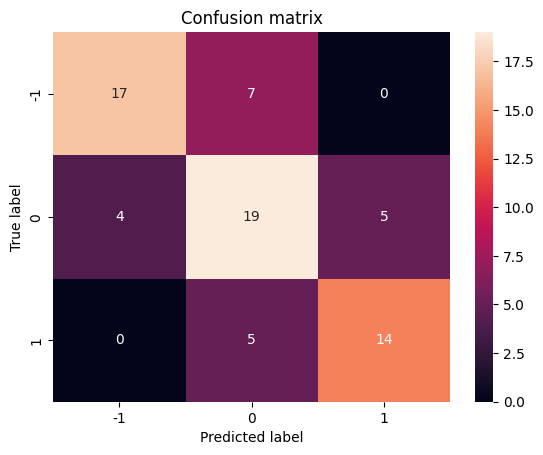

In [26]:
features = ["inflation", "rate", "usd"]

# Создаем копию признаков
data = X[features].copy()

# добавляем лаги целевой переменной
for i in range(1, study.best_params["n_lags"] + 1):
    data[f"lag{i}_target"] = y.shift(i)

# для всех экзогенных признаков
for feature in ["inflation", "rate", "usd"]:
    # добавляем рост
    data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
    features.append(f"growth_{feature}")

# для всех признаков добавляем лаги
for feature in features:
    for i in range(1, study.best_params["n_lags"]):
        data[f"lag{i}_{feature}"] = data[feature].shift(i)

model = KNeighborsClassifier(
    study.best_params["n_neighbors"],
    weights=study.best_params["weights"],
    p=study.best_params["p"],
    algorithm="brute",
)

# заполняем пропуски следующими значениями
data.bfill(inplace=True)

# считаем метрики на кросс валидации
metric, _ = calc_metrics(data.values, y, model, name="TimeSeries way KNN", plot=True, calc_jobs=-1)

In [27]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.704225,0.708239,0.708229,0.711692,0.819984,0.823556
K-neighbors tf_idf pca,0.676056,0.687194,0.684106,0.690773,0.801532,0.806358
K-neighbors word2vec,0.647887,0.629487,0.628759,0.739583,0.773496,0.776707
K-neighbors weighted word2vec,0.647887,0.629487,0.628759,0.739583,0.788023,0.789826
lag target Random Forest,0.521127,0.526519,0.531642,0.544029,0.731007,0.738598
"lag target, rate Random Forest",0.605634,0.618363,0.605368,0.644444,0.731230,0.739525
"lag target, rate, usd Random Forest",0.577465,0.582126,0.569967,0.632840,0.752053,0.759921
"lag target, rate, usd, inflation Random Forest",0.661972,0.670210,0.660610,0.700436,0.748025,0.753910
"lag target, rate, usd, inflation, growth Random Forest",0.676056,0.686532,0.674499,0.711310,0.759706,0.765801
TimeSeries way Random Forest,0.605634,0.606619,0.595760,0.659621,0.770320,0.777869


Классификация с помощью k ближайших соседей показала себя получше случайного леса, возможно из-за того что у нас очень мало данных, попробуем бустинг.

### CatBoost tuning hyperparameters

In [28]:
def objective(trial):
    # параметры для перебора
    params = {
        "n_lags": trial.suggest_int("n_lags", 2, 5),
        "depth": trial.suggest_int("depth", 3, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 1e-1),
    }

    features = ["inflation", "rate", "usd"]

    # Создаем копию признаков
    data = X[features].copy()

    # добавляем лаги целевой переменной
    for i in range(1, params["n_lags"] + 1):
        data[f"lag{i}_target"] = y.shift(i)

    # для всех экзогенных признаков
    for feature in ["inflation", "rate", "usd"]:
        # добавляем рост
        data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
        features.append(f"growth_{feature}")

    # для всех признаков добавляем лаги
    for feature in features:
        for i in range(1, params["n_lags"]):
            data[f"lag{i}_{feature}"] = data[feature].shift(i)

    model = CatBoostClassifier(
        iterations=100,
        depth=params["depth"],
        l2_leaf_reg=params["l2_leaf_reg"],
        random_state=42,
        verbose=0,
        early_stopping_rounds=20,
        task_type='GPU',
    )

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(data.values, y, model, name=" ", plot=False)

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True, catch=(ValueError,))

Best trial: 21. Best value: 0.780636: 100%|██████████| 100/100 [3:20:47<00:00, 120.48s/it] 


In [29]:
study.best_params

{'n_lags': 4, 'depth': 9, 'l2_leaf_reg': 0.028367816991284336}

Посотрим на лучшую модель подробнее.

              precision    recall  f1-score   support

        -1.0       0.74      0.71      0.72        24
         0.0       0.59      0.61      0.60        28
         1.0       0.68      0.68      0.68        19

    accuracy                           0.66        71
   macro avg       0.67      0.67      0.67        71
weighted avg       0.66      0.66      0.66        71



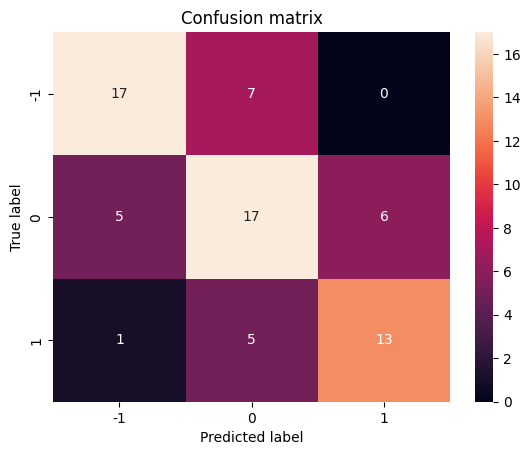

In [30]:
features = ["inflation", "rate", "usd"]

# Создаем копию признаков
data = X[features].copy()

# добавляем лаги целевой переменной
for i in range(1, study.best_params["n_lags"] + 1):
    data[f"lag{i}_target"] = y.shift(i)

# для всех экзогенных признаков
for feature in ["inflation", "rate", "usd"]:
    # добавляем рост
    data[f"growth_{feature}"] = data[feature] / data[feature].shift(1)
    features.append(f"growth_{feature}")

# для всех признаков добавляем лаги
for feature in features:
    for i in range(1, study.best_params["n_lags"]):
        data[f"lag{i}_{feature}"] = data[feature].shift(i)

model = CatBoostClassifier(
    iterations=100,
    depth=study.best_params["depth"],
    l2_leaf_reg=study.best_params["l2_leaf_reg"],
    random_state=42,
    verbose=False,
    early_stopping_rounds=20,
    task_type='GPU',
)

# считаем метрики на кросс валидации
metric, _ = calc_metrics(data.values, y, model, name="TimeSeries way CatBoost", plot=True)

In [31]:
metrics = pd.concat([metrics, metric])
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
K-neighbors tf_idf,0.704225,0.708239,0.708229,0.711692,0.819984,0.823556
K-neighbors tf_idf pca,0.676056,0.687194,0.684106,0.690773,0.801532,0.806358
K-neighbors word2vec,0.647887,0.629487,0.628759,0.739583,0.773496,0.776707
K-neighbors weighted word2vec,0.647887,0.629487,0.628759,0.739583,0.788023,0.789826
lag target Random Forest,0.521127,0.526519,0.531642,0.544029,0.731007,0.738598
"lag target, rate Random Forest",0.605634,0.618363,0.605368,0.644444,0.731230,0.739525
"lag target, rate, usd Random Forest",0.577465,0.582126,0.569967,0.632840,0.752053,0.759921
"lag target, rate, usd, inflation Random Forest",0.661972,0.670210,0.660610,0.700436,0.748025,0.753910
"lag target, rate, usd, inflation, growth Random Forest",0.676056,0.686532,0.674499,0.711310,0.759706,0.765801
TimeSeries way Random Forest,0.605634,0.606619,0.595760,0.659621,0.770320,0.777869


In [32]:
metrics.to_csv('metrics.csv')

Лучше других себя показал метод k ближайших соседей, использовавший лаговые признаки всех переменных в диапазоне от 1 до 3. Проанализировав матрицу ошибок можем сделать вывод, что модель одинаково хорошо детектирует все виды классов, и не разу не перепутала повышение ставки с понижением. В данных нет таких кейсов где за повышением сразу следует понижение ставки и наоборот, в результате чего хоть модель и не показывает очень высокого качества, но и не допускает грубых ошибок(вместо повышения предсказывает понижение и наоборот)